In [1]:
import numpy as np 
import pandas as pd 
from data_processing import generate_vocab, process_data, create_dataloaders
from model import get_pretrained_emb, EncoderRNN, DecoderRNN, DecoderAttnRNN, EncoderDecoder, EncoderDecoderAttn
from train_eval import train_and_eval, count_parameters, summarize_results, load_experiment_log, \
    plot_single_learning_curve, plot_multiple_learning_curves
import pickle as pkl 
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# params required for generating data loaders 

SRC_LANG = 'vi'
TARG_LANG = 'en'

SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 
TARG_VOCAB_SIZE = 30000 

BATCH_SIZE = 64 

In [3]:
# takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [4]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, filter_long=False)
data_minibatch = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=BATCH_SIZE, filter_long=False) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=1000, filter_long=False)

In [5]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [6]:
# model architecture params 
NETWORK_TYPE = 'rnn'
RNN_CELL_TYPE = 'gru'
NUM_LAYERS = 2 
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0
DEC_DROPOUT = 0
ATTENTION_TYPE = 'additive'

# training params  
NUM_EPOCHS = 5
LR = 0.0003 # 0.0005
OPTIMIZER = 'Adam'
LAZY_TRAIN = False

# name the model and experiment 
EXPERIMENT_NAME = 'hyperparameter_tuning_num_layers'
if NETWORK_TYPE == 'rnn': 
    MODEL_NAME = '{}-rnn-{}-attn'.format(SRC_LANG, ATTENTION_TYPE)
elif NETWORK_TYPE == 'cnn': 
    MODEL_NAME = '{}-cnn'.format(SRC_LANG)

In [7]:
# store as dict to save to results later 
params = {'experiment_name': EXPERIMENT_NAME,'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
          'rnn_cell_type': RNN_CELL_TYPE, 'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 
          'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 'src_vocab_size': SRC_VOCAB_SIZE, 
          'targ_vocab_size': TARG_VOCAB_SIZE, 'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 
          'dec_hidden_dim': DEC_HIDDEN_DIM, 'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 
          'clip_grad_max_norm': CLIP_GRAD_MAX_NORM, 'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'attention_type': ATTENTION_TYPE, 'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 
          'learning_rate': LR, 'optimizer': OPTIMIZER, 'lazy_train': LAZY_TRAIN} 

In [8]:
for candidate in [4, 3, 2, 1]: 
    
    print("Training with num_layers = {}".format(candidate))
    
    # overwrite relevant key-value in params 
    params['num_layers'] = candidate 
    params['model_name'] = '{}-rnn-{}-attn-{}-layers'.format(SRC_LANG, ATTENTION_TYPE, candidate)
    
    # instantiate model 
    encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=candidate, 
                         src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=ENC_DROPOUT, 
                         pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))
    decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
                             num_layers=candidate, targ_vocab_size=TARG_VOCAB_SIZE, 
                             src_max_sentence_len=SRC_MAX_SENTENCE_LEN, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                             dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
                             pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                    vocab[TARG_LANG]['token2id']))
    model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 
    
    # train and eval 
    model, results = train_and_eval(
        model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
        params=params, vocab=vocab, print_intermediate=500, save_checkpoint=True, save_to_log=True, 
        lazy_eval=True, print_attn=False, inspect_samples=3)

Training with num_layers = 4
Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.26, Train BLEU: 0.00, Val BLEU: 0.06, Minutes Elapsed: 0.10
Sampling from val predictions...
Source: nếu không , những chỗ như chồng và khuôn_mặt cô
Reference: areas like her husband and her face , which
Model: <SOS> and the the the the the the the the

Source: tôi nhận_ra tôi rất là may_mắn khi có_thể thay_đổi những
Reference: i &apos;d also note that i &apos;m quite privileged
Model: <SOS> and the the the the the the the the

Source: em la_hét nhiều . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: he screamed a lot . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> and the the the the the the the the



Epoch: 0.24, Train Loss: 0.00, Val Loss: 6.12, Train BLEU: 0.00, Val BLEU: 1.51, Minutes Elapsed: 9.17
Sampling from val predictions...
Source: và tôi thấy cha_mẹ họ và bố họ như cha
Reference: and i see their parents and their fathers who
Model: <SOS> and the , , , , , , ,

Source: ở đây chúng_ta có_một đoạn phim của các giây thanh_quản
Reference: so here we have a video of the vibrating
Model: <SOS> but , , , , , , , ,

Source: vì thế nên hôm_nay , với tôi , không sợ
Reference: so today , for me , being fearless means
Model: <SOS> so , , , , , , , ,



Epoch: 0.48, Train Loss: 0.00, Val Loss: 5.76, Train BLEU: 0.00, Val BLEU: 3.50, Minutes Elapsed: 18.25
Sampling from val predictions...
Source: cám_ơn các bạn . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . . <EOS> <EOS> <EOS> <EOS> <EOS>

Source: vậy không_gian bị bỏ_bê này đã trở_thành một không_gian kiến_tạo
Reference: so this neglected space became a constructive one ,
Model: <SOS> the the the the the the the the the

Source: ở new_york , chỉ có <UNK> ngàn người da_đen và
Reference: and there are only <UNK> young black and latino
Model: <SOS> now , , , , , , , ,



Epoch: 0.72, Train Loss: 0.00, Val Loss: 5.38, Train BLEU: 0.00, Val BLEU: 5.26, Minutes Elapsed: 27.32
Sampling from val predictions...
Source: chào . xin cảm_ơn . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: peace . thank you . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> thank you . . . . . <EOS> <EOS>

Source: tôi chỉ là một người phụ_nữ muốn chia_sẻ câu_chuyện của
Reference: i &apos;m just one woman with a story to
Model: <SOS> i &apos;m a a a a a a a

Source: lòng tốt từ người đàn_ông xa_lạ trở_thành biểu_tượng hy_vọng mới
Reference: the kind stranger symbolized new hope for me and
Model: <SOS> the are of of of of of of the



Epoch: 0.96, Train Loss: 0.00, Val Loss: 5.16, Train BLEU: 0.00, Val BLEU: 6.12, Minutes Elapsed: 36.39
Sampling from val predictions...
Source: đối_với một_số người , họ đã được kết_nối với một
Reference: for some of them , it &apos;s given them
Model: <SOS> in they , , , , a a a

Source: vậy_nên cái mà tôi đang nói đến_là tinh_thần kinh_doanh là
Reference: so what i &apos;m saying is that entrepreneurship is
Model: <SOS> the i i i i i is is is

Source: tôi không_thể nói cụ_thể về việc mình đã trốn khỏi
Reference: i can &apos;t reveal many details &#91; about &#93;
Model: <SOS> i i &apos;t to to to the the the



Epoch: 1.00, Train Loss: 0.00, Val Loss: 5.15, Train BLEU: 0.00, Val BLEU: 5.93, Minutes Elapsed: 37.97
Sampling from val predictions...
Source: một trong số điều thông_minh nhất <UNK> đã làm ,
Reference: one of the smartest things <UNK> did , from
Model: <SOS> one of of of of of of of ,

Source: những gì tôi làm , và những gì tôi làm
Reference: everything i do , and everything i do professionally
Model: <SOS> what i i , , , and and and

Source: ở cuối đường , anh ta giục chúng_tôi rời xe
Reference: at the end of the road , he urged
Model: <SOS> at the , , , we we the the



Epoch: 1.24, Train Loss: 0.00, Val Loss: 5.03, Train BLEU: 0.00, Val BLEU: 7.49, Minutes Elapsed: 46.98
Sampling from val predictions...
Source: ngay lúc_này , có_thể bạn đang nghĩ , " ồ
Reference: right now , maybe you &apos;re thinking , &quot;
Model: <SOS> so , , you , , , &quot; &quot;

Source: trong những năm taliban , tôi nhớ rằng có những
Reference: during taliban years , i remember there were times
Model: <SOS> in in , i i i i i i

Source: nhưng sau đó tôi đã nói , tôi muốn có
Reference: but then i said , i want to have
Model: <SOS> but i i said , i i i i



Epoch: 1.48, Train Loss: 0.00, Val Loss: 4.90, Train BLEU: 0.00, Val BLEU: 8.30, Minutes Elapsed: 56.00
Sampling from val predictions...
Source: kofi được cứu từ 1 làng chài . <EOS> <PAD>
Reference: kofi was rescued from a fishing village . <EOS>
Model: <SOS> they was a a a . . <EOS> <EOS>

Source: cám_ơn các bạn . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

Source: nói rằng em muốn được là người_mẫu khi em lớn_lên
Reference: saying that you want to be a model when
Model: <SOS> the , , he to to be to to



Epoch: 1.72, Train Loss: 0.00, Val Loss: 4.78, Train BLEU: 0.00, Val BLEU: 8.93, Minutes Elapsed: 65.04
Sampling from val predictions...
Source: điều mà bạn nên làm là đấu_tranh cho sự tự_chủ
Reference: but you have to fight for your <UNK> today
Model: <SOS> what what you do is is is is the

Source: cảm_ơn <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> . <EOS> <EOS> <EOS> <EOS>

Source: thậm_chí anh ta chĩa súng vào đầu tôi , đẩy
Reference: even though he held those loaded guns to my
Model: <SOS> he he &apos;t to my my , , ,



Epoch: 1.96, Train Loss: 0.00, Val Loss: 4.73, Train BLEU: 0.00, Val BLEU: 8.93, Minutes Elapsed: 74.11
Sampling from val predictions...
Source: ước_mơ lớn nhất của tôi là trở_thành một kỹ_sư máy_bay
Reference: so my big dream is to become an aircraft
Model: <SOS> the of of of is is a a a

Source: đừng hiểu_lầm tôi . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: now don &apos;t get me wrong . <EOS> <PAD>
Model: <SOS> don &apos;t &apos;t . . <EOS> <EOS> <EOS> <EOS>

Source: vậy_nên cái mà tôi làm trong năm đầu_tiên tại <UNK>
Reference: and so what i did in <UNK> that first
Model: <SOS> so what i i i in in in first



Epoch: 2.00, Train Loss: 0.00, Val Loss: 4.74, Train BLEU: 0.00, Val BLEU: 9.15, Minutes Elapsed: 75.69
Sampling from val predictions...
Source: chúng_tôi tình_cờ quay_lại new_york đúng một năm sau đó ,
Reference: we happened to be back in new york exactly
Model: <SOS> we we a a a a , , ,

Source: lò vi_sóng cũng có hệ_thống hoạt_động tương_tự . <EOS> <PAD>
Reference: so a microwave is a similar system . <EOS>
Model: <SOS> the system system system system system system system system

Source: và chiếc hộp đồng_hồ đo làm_cho <UNK> tắt . <EOS>
Reference: and the indicator box makes the lights flash .
Model: <SOS> and the the to to to . . .



Epoch: 2.24, Train Loss: 0.00, Val Loss: 4.71, Train BLEU: 0.00, Val BLEU: 9.74, Minutes Elapsed: 84.71
Sampling from val predictions...
Source: bây_giờ tôi muốn giới_thiệu các bạn với những người em_trai
Reference: now i &apos;d like to introduce you to my
Model: <SOS> now i i to to to with with with

Source: đây là một trong những kế_hoạch của tôi . đây
Reference: now this is one of my plans . this
Model: <SOS> this is one one of . . . .

Source: một đứa bị kẹt trong dòng nước . <EOS> <PAD>
Reference: one of them got caught up in the water
Model: <SOS> a &apos;s a in in . <EOS> <EOS> <EOS>



Epoch: 2.48, Train Loss: 0.00, Val Loss: 4.68, Train BLEU: 0.00, Val BLEU: 9.73, Minutes Elapsed: 93.73
Sampling from val predictions...
Source: vì có mắc chứng tự_kỷ hay không , sự khác_biệt
Reference: because autistic or not , the differences that we
Model: <SOS> because there are are , , , , ,

Source: bảo_trợ , tôi đối xử với tất_cả mọi người từ
Reference: patronizing , i treat everybody from another culture as
Model: <SOS> now , i i to all all all from

Source: vì_thế họ giết sư_tử . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: so they kill the lions . <EOS> <PAD> <PAD>
Model: <SOS> so they they . . <EOS> <EOS> <EOS> <EOS>



Epoch: 2.72, Train Loss: 0.00, Val Loss: 4.60, Train BLEU: 0.00, Val BLEU: 9.99, Minutes Elapsed: 102.77
Sampling from val predictions...
Source: dearborn , michigan . henry ford . <EOS> <PAD> <PAD>
Reference: <UNK> , michigan . henry ford . <EOS> <PAD>
Model: <SOS> <UNK> , ben . . . <EOS> <EOS> <EOS>

Source: tại_sao xã_hội chúng_tôi tiếp_tục là một xã_hội phân_cực và thống_trị
Reference: why does our society continue to be polarized and
Model: <SOS> why why we opportunity opportunity opportunity opportunity society society

Source: và chúng_tôi giúp họ tiến_hành tìm_kiếm sự hiểu_biết , vì
Reference: and then we help them to go and find
Model: <SOS> and we asked them them , , , because



Epoch: 2.96, Train Loss: 0.00, Val Loss: 4.56, Train BLEU: 0.00, Val BLEU: 10.31, Minutes Elapsed: 111.82
Sampling from val predictions...
Source: một cây dưới gối chỗ giường ngủ của chúng_tôi cây
Reference: he kept one under the pillows on our bed
Model: <SOS> a &apos;s a our our our our the our

Source: đây không_phải nói người mẹ không quan_trọng trong thành_công_của chúng_ta
Reference: it &apos;s not to say that our mothers aren
Model: <SOS> this &apos;s not not &apos;t &apos;t &apos;t &apos;t in

Source: vậy_là chúng_tôi già hoá mẫu_vật , đặt nhiều tải_trọng lên
Reference: so we did aging on the samples , did
Model: <SOS> so we we to to , , , ,



Epoch: 3.00, Train Loss: 0.00, Val Loss: 4.58, Train BLEU: 0.00, Val BLEU: 10.11, Minutes Elapsed: 113.39
Sampling from val predictions...
Source: tôi nhìn_thấy xe_lăn được mua_bán giống_như xe cũ vậy .
Reference: i see wheelchairs bought and sold like used cars
Model: <SOS> i i the the as as as the the

Source: lần đầu_tiên , tôi đang lái_xe để tìm một bãi_biển
Reference: the first time , i was driving to find
Model: <SOS> the first time , i i to to a

Source: việc người bắc triều_tiên phải che dấu danh_tính của mình
Reference: it &apos;s tragic that north koreans have to hide
Model: <SOS> the first of to to to to the the



Epoch: 3.24, Train Loss: 0.00, Val Loss: 4.56, Train BLEU: 0.00, Val BLEU: 10.83, Minutes Elapsed: 122.37
Sampling from val predictions...
Source: đây là tôi trong cùng một ngày khi chụp bức
Reference: here &apos;s me on the same day as this
Model: <SOS> this is i a a day day day a

Source: tôi muốn phản_kháng lại vì bạn biết sao không ?
Reference: i want to challenge that . do you know
Model: <SOS> i i to to to i , i know

Source: vậy chúng_tôi đã làm được gì ? chúng_tôi đang tiến_hành
Reference: so what &apos;s being done ? well , we
Model: <SOS> so what did we ? ? we we we



Epoch: 3.48, Train Loss: 0.00, Val Loss: 4.53, Train BLEU: 0.00, Val BLEU: 10.32, Minutes Elapsed: 131.34
Sampling from val predictions...
Source: khi sắp tới sinh_nhật lần thứ 3 của con gái
Reference: approaching my daughter &apos;s third birthday , my wife
Model: <SOS> when , the the the to three the three

Source: họ còn lâu mới bị tuyệt_chủng . <EOS> <PAD> <PAD>
Reference: they are far from being extinct . <EOS> <PAD>
Model: <SOS> they &apos;re still . . . . <EOS> <EOS>

Source: còn khi chúng_tôi ở sau cánh_gà , chúng_tôi đưa ra
Reference: and when we &apos;re backstage , we give an
Model: <SOS> when when we we in , the we we



Epoch: 3.72, Train Loss: 0.00, Val Loss: 4.46, Train BLEU: 0.00, Val BLEU: 11.42, Minutes Elapsed: 140.38
Sampling from val predictions...
Source: em run_rẩy khi thuyền của chúng_tôi đến gần , cứ
Reference: he was trembling when our boat approached , frightened
Model: <SOS> so children went the the , , , ,

Source: <UNK> là lực_lượng cảnh_sát mật hoạt_động ở đông đức .
Reference: <UNK> was the secret police in east germany .
Model: <SOS> the is a a of in in . <EOS>

Source: tất_cả những điều đó hoàn_toàn có_thể chỉ với chiếc điện_thoại_di_động
Reference: all this is possible with your mobile phone .
Model: <SOS> all that that that that to to to the



Epoch: 3.96, Train Loss: 0.00, Val Loss: 4.46, Train BLEU: 0.00, Val BLEU: 11.08, Minutes Elapsed: 149.41
Sampling from val predictions...
Source: cái quan_trọng nhất là khát_vọng . <EOS> <PAD> <PAD> <PAD>
Reference: the most important thing is passion . <EOS> <PAD>
Model: <SOS> the most important important is <EOS> . <EOS> <EOS>

Source: nơi đây cũng là nơi mà trung_tâm di_tản đã thu_thập
Reference: this happened to also be a place in the
Model: <SOS> now this also the the that has has the

Source: có một câu_chuyện rất vui mà tôi đọc được trên
Reference: there &apos;s a lovely story that i read in
Model: <SOS> there &apos;s a a story i i i to



Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.47, Train BLEU: 0.00, Val BLEU: 11.28, Minutes Elapsed: 150.99
Sampling from val predictions...
Source: tôi làm dự_án này năm_ngoái , và bắt_đầu nhận được
Reference: i made this last year , and started receiving
Model: <SOS> i i this this project and and and and

Source: tôi cũng không biết rằng giai_đoạn thứ hai là cô_lập
Reference: i also didn &apos;t know that the second step
Model: <SOS> i i &apos;t know that the the the between

Source: nhưng những cuộc trao_đổi hiệu_quả không_thể diễn ra nếu các
Reference: but these great conversations can &apos;t occur if our
Model: <SOS> but the the of &apos;t &apos;t &apos;t &apos;t if



Epoch: 4.24, Train Loss: 0.00, Val Loss: 4.50, Train BLEU: 0.00, Val BLEU: 11.49, Minutes Elapsed: 159.93
Sampling from val predictions...
Source: vì đó là lần đầu_tiên tôi biết rằng đồng_bào của
Reference: this was the first time i heard that people
Model: <SOS> so that was first first i i that the

Source: nếu bạn không phải là thợ làm_vườn thì bạn không_phải
Reference: if you ain &apos;t a gardener , you ain
Model: <SOS> if you don not the the good you you

Source: nô_lệ ngày_nay phục_vụ cho thương_mại , hàng_hoá mà người nô_lệ
Reference: today &apos;s slavery is about commerce , so the
Model: <SOS> the is is is , , , , ,



Epoch: 4.48, Train Loss: 0.00, Val Loss: 4.48, Train BLEU: 0.00, Val BLEU: 11.13, Minutes Elapsed: 168.94
Sampling from val predictions...
Source: vì không có kền_kền nên mới có sự tràn_lan về
Reference: because there are no vultures , there &apos;s been
Model: <SOS> because there &apos;s no new of the &apos;s about

Source: ý_tưởng đầu_tiên mà tôi có được là sử_dụng lửa ,
Reference: and the first idea i got was to use
Model: <SOS> the first first that that i was was is

Source: cô cũng đã có bản_sao của bức ảnh . <EOS>
Reference: she also had <UNK> . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> she was still the of the . . .



Epoch: 4.72, Train Loss: 0.00, Val Loss: 4.44, Train BLEU: 0.00, Val BLEU: 12.20, Minutes Elapsed: 177.93
Sampling from val predictions...
Source: thuật_ngữ ngăn_cản chúng_tôi hiểu được ý_tưởng của anh . <EOS>
Reference: jargon is a barrier to our understanding of your
Model: <SOS> our means our we of we . . <EOS>

Source: và cuối_cùng , tôi đã có một thoả_thuận với họ
Reference: so at the end , i had a settlement
Model: <SOS> and finally , , i i had a with

Source: trong thần_thoại hindu , <UNK> là thần kền_kền , ông
Reference: in hindu mythology , <UNK> was the <UNK> god
Model: <SOS> in the the , the is is , ,



Epoch: 4.96, Train Loss: 0.00, Val Loss: 4.46, Train BLEU: 0.00, Val BLEU: 11.52, Minutes Elapsed: 186.97
Sampling from val predictions...
Source: ông ấy nở một nụ cười rất lớn , điều
Reference: there was a big smile on his face which
Model: <SOS> he he a a of , , , ,

Source: như tôi , họ có mơ_ước lớn . <EOS> <PAD>
Reference: like me , they are dreaming big . <EOS>
Model: <SOS> like i , they have got . <EOS> <EOS>

Source: khi lớn lên , em trở_nên càng khác_biệt , và
Reference: and as he grew older , he grew more
Model: <SOS> when i was was up , , was to



Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.49, Train BLEU: 0.00, Val BLEU: 11.34, Minutes Elapsed: 188.52
Sampling from val predictions...
Source: <UNK> tiếp tuc đánh tôi một đến hai lần mỗi
Reference: <UNK> proceeded to beat me once or twice a
Model: <SOS> i work me me me me me me of

Source: không có <UNK> . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: there were no back doors . <EOS> <PAD> <PAD>
Model: <SOS> there &apos;s no . . . <EOS> &apos;s .

Source: chúng_tôi giấu sách_vở trong giỏ <UNK> như_thế mọi người sẽ
Reference: we would cover our books in grocery bags so
Model: <SOS> we we we in in in the in in

Model training completed in 188 minutes with 4.44 best validation loss and 12.20 best validation BLEU.
Training with num_layers = 3
Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.25, Train BLEU: 0.00, Val BLEU: 0.07, Minutes Elapsed: 0.09
Sampling from val predictions...
Source: chúng thật_sự là những gã gom rác tự_nhiên . <EOS>
Reference: they &apos;re our natural garbage colle

Epoch: 0.24, Train Loss: 0.00, Val Loss: 6.08, Train BLEU: 0.00, Val BLEU: 2.65, Minutes Elapsed: 8.69
Sampling from val predictions...
Source: và rồi sư_tử nhảy vào và giết gia_súc . <EOS>
Reference: so he jumps in and kills the animals .
Model: <SOS> and that &apos;s , . . . . .

Source: và thực_tế là_vì tâm_trí của các em tôi không phù_hợp
Reference: and in fact , because their minds don &apos;t
Model: <SOS> and the &apos;s that that that that that that

Source: bạn sẽ bất_ngờ với những gì mà mảnh_đất có_thể làm
Reference: you &apos;d be surprised what the soil could do
Model: <SOS> so &apos;s a a a a a a a



Epoch: 0.48, Train Loss: 0.00, Val Loss: 5.49, Train BLEU: 0.00, Val BLEU: 4.00, Minutes Elapsed: 17.26
Sampling from val predictions...
Source: <UNK> là biểu_tượng của người bảo_vệ và tình mẹ ,
Reference: <UNK> was the symbol of the protector and the
Model: <SOS> they have to and and and and and ,

Source: nhưng vẫn hi_vọng ngày nào đó có_thể rời_khỏi căn_nhà này
Reference: &quot; we hope still , though , that we
Model: <SOS> but the , that that that that that that

Source: vì_thế chúng_ta được dạy rằng " sự khoan_dung của ta
Reference: thus we are told that &quot; my mercy <UNK>
Model: <SOS> so we we we , , , , ,



Epoch: 0.72, Train Loss: 0.00, Val Loss: 5.16, Train BLEU: 0.00, Val BLEU: 6.56, Minutes Elapsed: 25.76
Sampling from val predictions...
Source: chúng_tôi thực_sự ngạc_nhiên về những người bản_địa , tại thung_lũng
Reference: and we were amazed that the local people ,
Model: <SOS> we we the the the the , , ,

Source: vậy_nên nhiều năm trước , tôi có ý_tưởng thế_này :
Reference: so years and years ago , i had this
Model: <SOS> in years , , , , , , ,

Source: nơi đây em đang tắm ở giếng , dội những
Reference: here he &apos;s seen taking a bath at the
Model: <SOS> so , is a in , , , ,



Epoch: 0.96, Train Loss: 0.00, Val Loss: 4.99, Train BLEU: 0.00, Val BLEU: 6.81, Minutes Elapsed: 34.14
Sampling from val predictions...
Source: việc người bắc triều_tiên phải che dấu danh_tính của mình
Reference: it &apos;s tragic that north koreans have to hide
Model: <SOS> the people the the the the the the the

Source: vì_thế họ giết sư_tử . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: so they kill the lions . <EOS> <PAD> <PAD>
Model: <SOS> so they they them . . . <EOS> <EOS>

Source: nếu không , những chỗ như chồng và khuôn_mặt cô
Reference: areas like her husband and her face , which
Model: <SOS> if if don &apos;t , , , , ,



Epoch: 1.00, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 7.13, Minutes Elapsed: 35.61
Sampling from val predictions...
Source: không_ai khởi_đầu một công_ty một_mình . không_ai cả . <EOS>
Reference: nobody started a company alone . no one .
Model: <SOS> it &apos;s not a a . . . .

Source: nhưng ngày_nay , nhiều thế_hệ gia_đình bị bắt_làm nô_lệ qua
Reference: yet today , entire families can be enslaved for
Model: <SOS> but , , , the the the the the

Source: nhiếp_ảnh là niềm đam_mê của tôi kể từ khi tôi
Reference: photography has been my passion ever since i was
Model: <SOS> it &apos;s my my my my my my my



Epoch: 1.24, Train Loss: 0.00, Val Loss: 4.82, Train BLEU: 0.00, Val BLEU: 9.11, Minutes Elapsed: 44.09
Sampling from val predictions...
Source: bạn thấy đó , một_số người có_thể không làm điều
Reference: you see , some people may not do it
Model: <SOS> you know , , can can &apos;t &apos;t &apos;t

Source: tương_đương với 50.000 đô - la mỹ ngày_nay . <EOS>
Reference: that equates to about $ 50,000 in today &apos;s
Model: <SOS> the &apos;s , . . . <EOS> <EOS> .

Source: tôi tham_gia vào các lực_lượng trong và ngoài libya để
Reference: i joined forces with many other <UNK> inside and
Model: <SOS> i i to in the and and and and



Epoch: 1.48, Train Loss: 0.00, Val Loss: 4.65, Train BLEU: 0.00, Val BLEU: 9.15, Minutes Elapsed: 52.61
Sampling from val predictions...
Source: bởi_vì nó rất rỗng , tất_cả tiếng_ồn sẽ biến mất
Reference: because it &apos;s very hollow , all the noise
Model: <SOS> because it &apos;s because , , , &apos;s ,

Source: tôi đã gặp <UNK> trong một đêm tháng_một , mưa
Reference: i met <UNK> on a cold , rainy january
Model: <SOS> i was a a a , , , ,

Source: ông ấy không bắt_đầu một_mình . <EOS> <PAD> <PAD> <PAD>
Reference: he wasn &apos;t alone when he started . <EOS>
Model: <SOS> he didn not . . <EOS> <EOS> <EOS> .



Epoch: 1.72, Train Loss: 0.00, Val Loss: 4.52, Train BLEU: 0.00, Val BLEU: 10.14, Minutes Elapsed: 61.12
Sampling from val predictions...
Source: tôi cũng từng là một nạn_nhân điển_hình bởi tôi chẳng
Reference: i was also a very typical victim because i
Model: <SOS> i &apos;m a a a of , , i

Source: tôi thấy các trung_tâm lọc máu mọc lên nhiều như
Reference: i see dialysis centers popping up like starbucks .
Model: <SOS> i i the the the the the the the

Source: sự tự_chủ và việc sống trong thời đại công_nghệ số
Reference: but <UNK> and living in the digital age is
Model: <SOS> the and and the are the in of the



Epoch: 1.96, Train Loss: 0.00, Val Loss: 4.44, Train BLEU: 0.00, Val BLEU: 10.55, Minutes Elapsed: 69.62
Sampling from val predictions...
Source: tôi đã có một_chút sợ_hãi . <EOS> <PAD> <PAD> <PAD>
Reference: that &apos;s a little bit scary . <EOS> <PAD>
Model: <SOS> i have had some of . <EOS> <EOS> <EOS>

Source: một đứa bị kẹt trong dòng nước . <EOS> <PAD>
Reference: one of them got caught up in the water
Model: <SOS> a &apos;s a in in in <EOS> <EOS> .

Source: một_số người thậm_chí không biết mình bị biến thành nô_lệ
Reference: some don &apos;t even know they &apos;re enslaved ,
Model: <SOS> some some people don &apos;t know know &apos;t to



Epoch: 2.00, Train Loss: 0.00, Val Loss: 4.48, Train BLEU: 0.00, Val BLEU: 10.18, Minutes Elapsed: 71.10
Sampling from val predictions...
Source: những cái hầm sâu tới cả trăm mét , họ
Reference: the shafts are up to 300 feet deep ,
Model: <SOS> the the of the to the , , the

Source: một là anh ta , cũng_như tôi , vừa tốt_nghiệp
Reference: one was that he , too , had just
Model: <SOS> one is , , he , he , was

Source: ở dãy himalayas , tôi thấy trẻ_em vác đá qua
Reference: in the himalayas , i found children carrying stone
Model: <SOS> in i , , i i been the the



Epoch: 2.24, Train Loss: 0.00, Val Loss: 4.40, Train BLEU: 0.00, Val BLEU: 11.57, Minutes Elapsed: 79.60
Sampling from val predictions...
Source: thế nên tôi đã lấy một bình ắc - quy
Reference: so i got an old car battery , an
Model: <SOS> so i i a a film -- i i

Source: đó là môt sự_cố cá_biệt , và anh ta sẽ
Reference: it was an isolated incident , and he was
Model: <SOS> it &apos;s the <UNK> , , and he &apos;s

Source: việc ổn_định cuộc_sống ở đây khó_khăn hơn nhiều so với
Reference: settling down in south korea was a lot more
Model: <SOS> the the is a is is the than than



Epoch: 2.48, Train Loss: 0.00, Val Loss: 4.35, Train BLEU: 0.00, Val BLEU: 10.98, Minutes Elapsed: 88.10
Sampling from val predictions...
Source: câu_hỏi tiếp_theo mà người_ta luôn hỏi tôi : " có_phải
Reference: the next question people always ask me is ,
Model: <SOS> the next question , ask me &quot; &quot; &quot;

Source: có hai loại kền_kền trên hành_tinh này . <EOS> <PAD>
Reference: so there &apos;s two types of vultures in this
Model: <SOS> there are are two of of . . <EOS>

Source: và trên chiếc đĩa cd , cái tôi cần đã
Reference: and on the c.d. , this was on .
Model: <SOS> and on the , , , i i ,



Epoch: 2.72, Train Loss: 0.00, Val Loss: 4.30, Train BLEU: 0.00, Val BLEU: 11.91, Minutes Elapsed: 96.58
Sampling from val predictions...
Source: cái mà chúng_ta phải nhìn đến đó là chúng_ta làm
Reference: what we have to look at is at how
Model: <SOS> what we we to to that we we we

Source: không , không_hề . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: no , it didn &apos;t . <EOS> <PAD> <PAD>
Model: <SOS> no , no . <EOS> . <EOS> . <EOS>

Source: tôi lúc_nào cũng tự_hỏi là tại_sao họ lại có điện
Reference: i always wondered why they had lights but we
Model: <SOS> i &apos;m the why why why why why why



Epoch: 2.96, Train Loss: 0.00, Val Loss: 4.26, Train BLEU: 0.00, Val BLEU: 11.61, Minutes Elapsed: 105.08
Sampling from val predictions...
Source: chứ không bao_giờ tôi có_thể tưởng_tượng rằng tôi sẽ phải
Reference: i could have never imagined that it would take
Model: <SOS> i i &apos;t see i i i could i

Source: chúng_ta có_thể thấy chúng di_chuyển đến rất nhiều quốc_gia khác
Reference: we can see that they travel different countries ,
Model: <SOS> we can see them different different different different different

Source: và đó là cách mà ánh_sáng chiếu về phía sư_tử
Reference: and that &apos;s how it looks to lions when
Model: <SOS> and that &apos;s how way &apos;s the the and



Epoch: 3.00, Train Loss: 0.00, Val Loss: 4.30, Train BLEU: 0.00, Val BLEU: 11.25, Minutes Elapsed: 106.57
Sampling from val predictions...
Source: khi mà những quả cà_chua bắt_đầu đạt , chín ,
Reference: when the tomatoes were nice and ripe and red
Model: <SOS> when we started of the the the , the

Source: chúng dọn_sạch những xác_chết đến tận xương . <EOS> <PAD>
Reference: they clean up carcasses right to the bone .
Model: <SOS> they need the to the . <EOS> . .

Source: sự sụp_đổ của bức tường berlin có_thể sẽ không tồn_tại
Reference: the fall of the berlin wall would maybe not
Model: <SOS> the the of of of of the the be



Epoch: 3.24, Train Loss: 0.00, Val Loss: 4.27, Train BLEU: 0.00, Val BLEU: 12.39, Minutes Elapsed: 115.13
Sampling from val predictions...
Source: bất_cứ ai khoẻ_mạnh hoặc mắc bệnh parkinson có_thể gọi tới
Reference: anyone healthy or with parkinson &apos;s can call in
Model: <SOS> the &apos;s the the to or , to be

Source: những người thông_thái nhất trong cộng <UNK> chẳng bao_giờ biết
Reference: the smartest people in your community you don &apos;t
Model: <SOS> the people of in the in , the in

Source: chào . xin cảm_ơn . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: peace . thank you . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> thank you thank you . <EOS> you . <EOS>



Epoch: 3.48, Train Loss: 0.00, Val Loss: 4.24, Train BLEU: 0.00, Val BLEU: 12.35, Minutes Elapsed: 123.67
Sampling from val predictions...
Source: vì những cuộc bầu_cử không đem lại hoà_bình , sự
Reference: for elections did not bring peace and stability and
Model: <SOS> because those of not not not , , ,

Source: bạn có_thể làm gì ? bạn làm được không ?
Reference: what can you do ? can you make it
Model: <SOS> what you you do ? do you do ?

Source: con chó của tôi là giống black lab , và
Reference: my dog is a black lab , and i
Model: <SOS> my my is is is , , and ,



Epoch: 3.72, Train Loss: 0.00, Val Loss: 4.23, Train BLEU: 0.00, Val BLEU: 12.76, Minutes Elapsed: 132.23
Sampling from val predictions...
Source: chúng_ta thấy đều cùng triệu_chứng . <EOS> <PAD> <PAD> <PAD>
Reference: we see all the same symptoms . <EOS> <PAD>
Model: <SOS> we see all . . . . <EOS> <EOS>

Source: khi ra khỏi hầm , người họ ướt_sũng bởi <UNK>
Reference: when they came out of the shaft , they
Model: <SOS> when the get out , the , , they

Source: chúng_tôi có cơ_hội để bắt_đầu tìm_kiếm những dấu_ấn sinh_học ban_đầu
Reference: we have the opportunity to start to search for
Model: <SOS> we have to opportunity to get the the the



Epoch: 3.96, Train Loss: 0.00, Val Loss: 4.22, Train BLEU: 0.00, Val BLEU: 11.90, Minutes Elapsed: 140.81
Sampling from val predictions...
Source: chúng dọn_sạch những xác_chết đến tận xương . <EOS> <PAD>
Reference: they clean up carcasses right to the bone .
Model: <SOS> they they the to the <EOS> <EOS> . .

Source: tuy_vậy , ngay khi tôi vừa_mới làm_quen với cuộc_sống ở
Reference: just as i was starting to get used to
Model: <SOS> but , as as as to to a results

Source: một là anh ta , cũng_như tôi , vừa tốt_nghiệp
Reference: one was that he , too , had just
Model: <SOS> one was , , he , , , i



Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.27, Train BLEU: 0.00, Val BLEU: 11.78, Minutes Elapsed: 142.29
Sampling from val predictions...
Source: vì nếu_như họ thấy có điều gì không tự_nhiên ,
Reference: if anything seemed unnatural , i could be imprisoned
Model: <SOS> because they they they that , course , ,

Source: tôi cũng không biết rằng giai_đoạn thứ hai là cô_lập
Reference: i also didn &apos;t know that the second step
Model: <SOS> i didn not know know the the the between

Source: quá sợ người chủ , em không_dám chạy_trốn , và
Reference: terrified of his master , he will not run
Model: <SOS> the , the , , the don &apos;t ,



Epoch: 4.24, Train Loss: 0.00, Val Loss: 4.25, Train BLEU: 0.00, Val BLEU: 12.48, Minutes Elapsed: 150.82
Sampling from val predictions...
Source: và câu trả_lời đầu_tiên của tôi là : " chị
Reference: and the first answer is , &quot; i don
Model: <SOS> and my first answer my my &quot; my ,

Source: điều đó giải_thích tại sao bằng_cấp tại <UNK> <UNK> và
Reference: which is why that ivy league degree and the
Model: <SOS> it makes why why <UNK> <UNK> <UNK> and and

Source: câu_hỏi cuối_cùng mà người_ta hỏi tôi là : " cảm_giác
Reference: so the last question people ask me is ,
Model: <SOS> the the question question question people ask &quot; &quot;



Epoch: 4.48, Train Loss: 0.00, Val Loss: 4.24, Train BLEU: 0.00, Val BLEU: 12.48, Minutes Elapsed: 159.37
Sampling from val predictions...
Source: nếu bạn nói với tôi rằng người đàn_ông thông_minh ,
Reference: if you had told me that this smart ,
Model: <SOS> if you tell to people the the are ,

Source: ngày khác chúng_tôi thức_dậy với tin_tức về vụ tàn_sát đại_sứ
Reference: on another day we wake up to the news
Model: <SOS> and we we we we on the the news

Source: cái ý_tưởng tìm_kiếm một công_nghệ khác_biệt đã hoàn_toàn vượt lên
Reference: the idea of finding a different technology had absolutely
Model: <SOS> the the idea a is that that has has



Epoch: 4.72, Train Loss: 0.00, Val Loss: 4.24, Train BLEU: 0.00, Val BLEU: 12.65, Minutes Elapsed: 167.95
Sampling from val predictions...
Source: ước_mơ lớn nhất của tôi là trở_thành một kỹ_sư máy_bay
Reference: so my big dream is to become an aircraft
Model: <SOS> my first my is was a a a a

Source: đó là ý_nghĩa của toàn_bộ dự_án này , phục_hồi những
Reference: that &apos;s all this project was about , about
Model: <SOS> that &apos;s the of of of this project project

Source: câu_hỏi khác mà mọi người hay hỏi là , tại_sao
Reference: the other question everybody asks is , why doesn
Model: <SOS> the other question that people , , why why



Epoch: 4.96, Train Loss: 0.00, Val Loss: 4.24, Train BLEU: 0.00, Val BLEU: 12.21, Minutes Elapsed: 176.55
Sampling from val predictions...
Source: bây_giờ tôi muốn giới_thiệu các bạn với những người em_trai
Reference: now i &apos;d like to introduce you to my
Model: <SOS> now i want to to introduce you to with

Source: nó trở_nên thật thiêng_liêng với chúng_tôi . <EOS> <PAD> <PAD>
Reference: it &apos;s really become sacred to us . <EOS>
Model: <SOS> it became us to us . . . <EOS>

Source: nó ngoài tầm kiểm_soát của em , và nó thật
Reference: it &apos;s out of your control , and it
Model: <SOS> it &apos;s a a her , , and it



Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.29, Train BLEU: 0.00, Val BLEU: 11.83, Minutes Elapsed: 178.03
Sampling from val predictions...
Source: tôi muốn tất_cả chúng_ta trở_thành những kẻ nổi_loạn xanh hoá
Reference: so i want us all to become <UNK> <UNK>
Model: <SOS> i want want all all all all all of

Source: hơn 85 phần_trăm kẻ bạo_hành là đàn_ông , và bạo_lực
Reference: over 85 percent of <UNK> are men , and
Model: <SOS> the percent percent percent the &apos;s the and and

Source: " thế tại_sao mọi người không cho chúng_tôi biết trước
Reference: &quot; why didn &apos;t you tell us ? &quot;
Model: <SOS> &quot; why , why do why why why why

Model training completed in 178 minutes with 4.22 best validation loss and 12.76 best validation BLEU.
Training with num_layers = 2
Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.23, Train BLEU: 0.00, Val BLEU: 0.07, Minutes Elapsed: 0.09
Sampling from val predictions...
Source: hơn năm trăm tình_nguyện viên toàn_cầu đã giúp trao_trả cho
Reference

Epoch: 0.24, Train Loss: 0.00, Val Loss: 5.90, Train BLEU: 0.00, Val BLEU: 3.06, Minutes Elapsed: 8.35
Sampling from val predictions...
Source: ông_ngoại của tôi là một người thật đáng khâm_phục vào
Reference: my grandfather was an extraordinary man for his time
Model: <SOS> so i &apos;m a to to , , ,

Source: lí_do là chúng đang bị đầu_độc , chúng bị đầu_độc
Reference: the reason is that they &apos;re getting poisoned ,
Model: <SOS> the , , , , , , , ,

Source: có_một nhóm chuyên_gia được mời đến để thảo_luận về tương_lai
Reference: there was a group of experts who were invited
Model: <SOS> the the a a a a a a a



Epoch: 0.48, Train Loss: 0.00, Val Loss: 5.27, Train BLEU: 0.00, Val BLEU: 5.94, Minutes Elapsed: 16.62
Sampling from val predictions...
Source: nó được xây_dựng từ nhựa_đường , và nhựa_đường là loại
Reference: it &apos;s made of asphalt , and asphalt is
Model: <SOS> it &apos;s a to , , and and ,

Source: khi chạy_trốn con sóng , để giữ lấy tính_mạng ,
Reference: as they had run from the wave , and
Model: <SOS> when we &apos;re to , , , , ,

Source: em không nói được , nhưng em truyền_đạt niềm_vui theo
Reference: he &apos;s <UNK> , but he communicates joy in
Model: <SOS> he said , , , , , , ,



Epoch: 0.72, Train Loss: 0.00, Val Loss: 4.90, Train BLEU: 0.00, Val BLEU: 8.62, Minutes Elapsed: 24.89
Sampling from val predictions...
Source: đúng vào lúc đó , có một người đàn_ông đã
Reference: at that moment , i heard one man &apos;s
Model: <SOS> he &apos;s , , there &apos;s a a of

Source: gần 200 tổ_chức được thiết_lập tại benghazi trong suốt thời_gian
Reference: almost 200 organizations were established in benghazi during and
Model: <SOS> so years the of the in in in the

Source: tôi muốn đưa nô_lệ ra ánh_sáng . <EOS> <PAD> <PAD>
Reference: i want to shine a light on slavery .
Model: <SOS> i want to to to the . . .



Epoch: 0.96, Train Loss: 0.00, Val Loss: 4.69, Train BLEU: 0.00, Val BLEU: 9.28, Minutes Elapsed: 33.18
Sampling from val predictions...
Source: và làm thế_nào chúng_ta chia_sẻ nhiều hơn những hy_vọng của
Reference: and how can we share more of our hopes
Model: <SOS> and that we we to to many of of

Source: một ngôi trường thật_sự . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: a real school . <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> a &apos;s of . <EOS> . . <EOS> <EOS>

Source: quân_cảnh không giúp ngăn_chặn sự lây_lan của bệnh_tật . <EOS>
Reference: mps do not help to prevent the spread of
Model: <SOS> it &apos;s not about the . . . .



Epoch: 1.00, Train Loss: 0.00, Val Loss: 4.69, Train BLEU: 0.00, Val BLEU: 8.84, Minutes Elapsed: 34.62
Sampling from val predictions...
Source: đối_với cô , sau hết mọi sự , những bức
Reference: for her , despite all of this , those
Model: <SOS> at , , , the , , , ,

Source: lần đầu đến đó , tôi đi xem qua 1
Reference: when we first arrived , i went to have
Model: <SOS> i i i to , i i to a

Source: cứ 20 phút , tôi phải chạy trở_lại xe dã_chiến
Reference: every 20 minutes , i &apos;d have to run
Model: <SOS> the the 20 , i i to to back



Epoch: 1.24, Train Loss: 0.00, Val Loss: 4.54, Train BLEU: 0.00, Val BLEU: 11.10, Minutes Elapsed: 42.86
Sampling from val predictions...
Source: những_ai trong khán_phòng có điện_thoại_di_động ? <EOS> <PAD> <PAD> <PAD>
Reference: who in the room has a mobile phone with
Model: <SOS> how are are ? ? <EOS> ? ? <EOS>

Source: trước_tiên , tại_sao chúng lại có ấn_tượng xấu như_vậy ?
Reference: first of all , why do they have such
Model: <SOS> first , , , why they they have ?

Source: <UNK> dãy các thông_tin . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: <UNK> thousand eight hundred thirty lines of information .
Model: <SOS> <UNK> &apos;s <EOS> . . <EOS> <EOS> <EOS> .



Epoch: 1.48, Train Loss: 0.00, Val Loss: 4.42, Train BLEU: 0.00, Val BLEU: 11.58, Minutes Elapsed: 51.08
Sampling from val predictions...
Source: nhưng hôm_nay tôi sẽ nói về bản_thân và chiếc điện_thoại
Reference: but today i will talk about me and my
Model: <SOS> but today i &apos;m going talk about about about

Source: dọn_dẹp trường_học , vệ_sinh nhà_cửa , sẵn_sàng cho việc đổi_mới
Reference: we cleaned schools . we <UNK> and gutted homes
Model: <SOS> a , , , , , , the ,

Source: trên hết , <UNK> bị bệnh lao , nhưng vẫn
Reference: on top of that , <UNK> has tuberculosis ,
Model: <SOS> in , , , , , , , ,



Epoch: 1.72, Train Loss: 0.00, Val Loss: 4.30, Train BLEU: 0.00, Val BLEU: 12.21, Minutes Elapsed: 59.32
Sampling from val predictions...
Source: và họ thả tôi ra . đó quả là một
Reference: and they let me go . it was a
Model: <SOS> and they they me . it it &apos;s a

Source: hiện_tại , tôi sống ở new orleans , và tôi
Reference: now , i live in new orleans , and
Model: <SOS> now , i &apos;m in in york , and

Source: hai điều quan_trọng nhất chúng_ta có là thời_gian và mối
Reference: two of the most valuable things we have are
Model: <SOS> two the the important that that we have is



Epoch: 1.96, Train Loss: 0.00, Val Loss: 4.23, Train BLEU: 0.00, Val BLEU: 13.02, Minutes Elapsed: 67.62
Sampling from val predictions...
Source: sau 2 giờ cuốc_bộ nữa , dấu_vết quanh_co bất_ngờ kết_thúc
Reference: after another two hours of hiking , the <UNK>
Model: <SOS> after two , , , the , , most

Source: có_thể sự thiếu_sót không chỉ là về mặt bình_quyền của
Reference: maybe what was missing was not the women only
Model: <SOS> it might be not not not a the of

Source: và làm thế_nào chúng_ta chia_sẻ nhiều hơn những hy_vọng của
Reference: and how can we share more of our hopes
Model: <SOS> and how we we take more many of of



Epoch: 2.00, Train Loss: 0.00, Val Loss: 4.26, Train BLEU: 0.00, Val BLEU: 12.53, Minutes Elapsed: 69.08
Sampling from val predictions...
Source: cùng một nhóm phụ_nữ tuyệt_vời , tôi đồng sáng_lập <UNK>
Reference: with an amazing group of women , i <UNK>
Model: <SOS> i a a , , i , i i

Source: bạn không_thể nào bị sỉ_nhục tồi_tệ hơn thế , và
Reference: you could not get a worse insult , and
Model: <SOS> you can &apos;t see by by of , and

Source: tôi , cùng hàng trăm tình_nguyện viên hiểu rằng không_thể
Reference: i , along with hundreds of other volunteers ,
Model: <SOS> i , also the of of of that that



Epoch: 2.24, Train Loss: 0.00, Val Loss: 4.19, Train BLEU: 0.00, Val BLEU: 13.19, Minutes Elapsed: 77.40
Sampling from val predictions...
Source: chúng_ta thấy giọng run , sự suy_nhược và xơ_cứng .
Reference: we see vocal tremor , weakness and rigidity .
Model: <SOS> we &apos;re the , and and and <EOS> .

Source: từ khi còn nhỏ , tôi đã từng làm_việc ở
Reference: since i was a small boy , i used
Model: <SOS> from i i , , , , i used

Source: và từ_đó bắt_đầu cuộc hành_trình tiến vào thế_giới nô_lệ hiện_đại
Reference: thus began my journey into modern day slavery .
Model: <SOS> and from the the to the the the the



Epoch: 2.48, Train Loss: 0.00, Val Loss: 4.13, Train BLEU: 0.00, Val BLEU: 13.42, Minutes Elapsed: 85.71
Sampling from val predictions...
Source: nhưng cũng là có chọn_lọc . <EOS> <PAD> <PAD> <PAD>
Reference: he has a selective one , though . <EOS>
Model: <SOS> but it also . . . <EOS> &apos;s <EOS>

Source: vì có mắc chứng tự_kỷ hay không , sự khác_biệt
Reference: because autistic or not , the differences that we
Model: <SOS> because there &apos;s or or , the , ,

Source: nó xảy_ra mọi nơi . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: it &apos;s everywhere . <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> it &apos;s everything . <EOS> . . <EOS> <EOS>



Epoch: 2.72, Train Loss: 0.00, Val Loss: 4.10, Train BLEU: 0.00, Val BLEU: 14.08, Minutes Elapsed: 93.95
Sampling from val predictions...
Source: tôi cùng_với nhóm của tôi , những mảnh_đất xanh l.
Reference: so me and my group , l.a. green grounds
Model: <SOS> i i my my , , , , my

Source: tôi có_thể cảm_nhận sự va_chạm từ những thân_thể bóng <UNK>
Reference: i can feel the brush of sweaty bodies passing
Model: <SOS> i can feel from from from the from from

Source: và tôi có được một công_tắc để có_thể tắt và
Reference: and i got a switch where i can switch
Model: <SOS> and i had a a to to can to



Epoch: 2.96, Train Loss: 0.00, Val Loss: 4.07, Train BLEU: 0.00, Val BLEU: 14.39, Minutes Elapsed: 102.21
Sampling from val predictions...
Source: cô ấy đã tự lau sạch chúng và dừng lại
Reference: she had started <UNK> them herself and stopped when
Model: <SOS> she was the and and and and and ,

Source: anh ta muốn biết mọi thứ về gia_đình tôi và
Reference: he wanted to know everything about my family and
Model: <SOS> he wanted to know what the my family and

Source: vì_vậy tôi phát vỡ sự yên_lặng . <EOS> <PAD> <PAD>
Reference: so i broke the silence . <EOS> <PAD> <PAD>
Model: <SOS> so i i the . . <EOS> . .



Epoch: 3.00, Train Loss: 0.00, Val Loss: 4.12, Train BLEU: 0.00, Val BLEU: 13.06, Minutes Elapsed: 103.64
Sampling from val predictions...
Source: hoạch_định là nụ hôn thần_chết đối_với doanh_nhân . <EOS> <PAD>
Reference: planning is the kiss of death of entrepreneurship .
Model: <SOS> sustainability is a to to the business . .

Source: l. a. dẫn đầu nước mỹ về diện_tích <UNK> mà
Reference: l.a. leads the united states in vacant lots that
Model: <SOS> and the the of of of the <UNK> the

Source: tôi muốn phản_kháng lại vì bạn biết sao không ?
Reference: i want to challenge that . do you know
Model: <SOS> i i to to you you you know know



Epoch: 3.24, Train Loss: 0.00, Val Loss: 4.08, Train BLEU: 0.00, Val BLEU: 14.33, Minutes Elapsed: 111.94
Sampling from val predictions...
Source: " bây_giờ con có_thể thật_sự đến trường rồi " ông
Reference: &quot; you can go to a real school now
Model: <SOS> &quot; &quot; can have go &quot; &quot; &quot; &quot;

Source: những chúng mang hai_nghĩa khác_biệt . <EOS> <PAD> <PAD> <PAD>
Reference: but they mean two different things . <EOS> <PAD>
Model: <SOS> they they are the different . <EOS> <EOS> <EOS>

Source: ông ấy trả_lời : " nếu ngươi muốn thì giết
Reference: &quot; kill me now , if you wish ,
Model: <SOS> he said said &quot; &quot; &quot; if you ,



Epoch: 3.48, Train Loss: 0.00, Val Loss: 4.04, Train BLEU: 0.00, Val BLEU: 14.00, Minutes Elapsed: 120.18
Sampling from val predictions...
Source: nhiếp_ảnh là niềm đam_mê của tôi kể từ khi tôi
Reference: photography has been my passion ever since i was
Model: <SOS> photography was my passion passion from i i i

Source: bạn có_thể phi_thường . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: you can be extraordinary . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> you can be . . <EOS> can . <EOS>

Source: nhưng ngày_nay , nhiều thế_hệ gia_đình bị bắt_làm nô_lệ qua
Reference: yet today , entire families can be enslaved for
Model: <SOS> but today , many world world the been by



Epoch: 3.72, Train Loss: 0.00, Val Loss: 4.04, Train BLEU: 0.00, Val BLEU: 15.15, Minutes Elapsed: 128.47
Sampling from val predictions...
Source: thật xúc_động và háo_hức . trước đó , tôi từng
Reference: now , it was emotional and it was inspiring
Model: <SOS> it &apos;s and . . . before , i

Source: <UNK> tiếp tuc đánh tôi một đến hai lần mỗi
Reference: <UNK> proceeded to beat me once or twice a
Model: <SOS> <UNK> <UNK> <UNK> a a a a two times

Source: bất_cứ ai khoẻ_mạnh hoặc mắc bệnh parkinson có_thể gọi tới
Reference: anyone healthy or with parkinson &apos;s can call in
Model: <SOS> anyone of the or or or be to be



Epoch: 3.96, Train Loss: 0.00, Val Loss: 4.03, Train BLEU: 0.00, Val BLEU: 14.80, Minutes Elapsed: 136.86
Sampling from val predictions...
Source: cửa_hàng rượu , đồ_ăn nhanh , <UNK> . <EOS> <PAD>
Reference: <UNK> stores , fast food , vacant lots .
Model: <SOS> the , the , . <EOS> <EOS> . <EOS>

Source: đây chính là cái di_sản được dựng nên cho tôi
Reference: and this is a legacy that was built for
Model: <SOS> this is is the legacy that the built to

Source: và thực_tế là_vì tâm_trí của các em tôi không phù_hợp
Reference: and in fact , because their minds don &apos;t
Model: <SOS> and it fact , i i my of i



Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 13.73, Minutes Elapsed: 138.32
Sampling from val predictions...
Source: tôi đã để vật mẫu vào lò , giờ tôi
Reference: so i put the specimen in , which i
Model: <SOS> i i i to into on my , my

Source: thật xúc_động và háo_hức . trước đó , tôi từng
Reference: now , it was emotional and it was inspiring
Model: <SOS> it &apos;s and , , , and , that

Source: những cái hầm sâu tới cả trăm mét , họ
Reference: the shafts are up to 300 feet deep ,
Model: <SOS> the the of the to the the the the



Epoch: 4.24, Train Loss: 0.00, Val Loss: 4.06, Train BLEU: 0.00, Val BLEU: 14.56, Minutes Elapsed: 146.54
Sampling from val predictions...
Source: và họ thả tôi ra . đó quả là một
Reference: and they let me go . it was a
Model: <SOS> and they they me it it it &apos;s a

Source: gia_đình của tôi không nghèo , và bản_thân tôi thì
Reference: my family was not poor , and myself ,
Model: <SOS> my my didn &apos;t , , and my my

Source: các bóng <UNK> tắt và đánh_lừa sư_tử làm_cho chúng nghĩ
Reference: the lights flash and trick the lions into thinking
Model: <SOS> the and and and and were them they they



Epoch: 4.48, Train Loss: 0.00, Val Loss: 4.03, Train BLEU: 0.00, Val BLEU: 14.24, Minutes Elapsed: 154.77
Sampling from val predictions...
Source: rồi bạn cần một cái máy , như bạn thấy
Reference: then you need a machine , like you see
Model: <SOS> and you need a new , you you see

Source: cảm_ơn <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thanks . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you <EOS> you . <EOS> <EOS> <EOS> <EOS>

Source: khi lớn lên , em trở_nên càng khác_biệt , và
Reference: and as he grew older , he grew more
Model: <SOS> when i i , , , i became a



Epoch: 4.72, Train Loss: 0.00, Val Loss: 4.06, Train BLEU: 0.00, Val BLEU: 15.59, Minutes Elapsed: 163.01
Sampling from val predictions...
Source: và đây là tôi bây_giờ . <EOS> <PAD> <PAD> <PAD>
Reference: and here &apos;s me today . <EOS> <PAD> <PAD>
Model: <SOS> and here is my i . <EOS> <EOS> .

Source: hơn năm trăm tình_nguyện viên toàn_cầu đã giúp trao_trả cho
Reference: over five hundred volunteers around the globe helped us
Model: <SOS> over years years of of the u.s. of the

Source: những_ai trong khán_phòng có điện_thoại_di_động ? <EOS> <PAD> <PAD> <PAD>
Reference: who in the room has a mobile phone with
Model: <SOS> what are in room of the future ? <EOS>



Epoch: 4.96, Train Loss: 0.00, Val Loss: 4.07, Train BLEU: 0.00, Val BLEU: 14.34, Minutes Elapsed: 171.23
Sampling from val predictions...
Source: trong kỉ_nguyên gia_tăng sự phân_tán của chúng_ta , điều này
Reference: in our age of increasing distractions , it &apos;s
Model: <SOS> in our , , our , , which &apos;s

Source: điều thú_vị là đồ_ăn nhanh bên đường đang giết chết
Reference: funny thing is , the <UNK> are killing more
Model: <SOS> the &apos;s interesting the the the is is the

Source: chúng_tôi đã gặp_may với việc lau ảnh bằng tay .
Reference: now , we were lucky with our <UNK> .
Model: <SOS> we we we we to with with with .



Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.11, Train BLEU: 0.00, Val BLEU: 14.00, Minutes Elapsed: 172.66
Sampling from val predictions...
Source: không , không_hề . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: no , it didn &apos;t . <EOS> <PAD> <PAD>
Model: <SOS> no , no . no . <EOS> &apos;s .

Source: chúng thật_sự là những gã gom rác tự_nhiên . <EOS>
Reference: they &apos;re our natural garbage collectors . <EOS> <PAD>
Model: <SOS> they are are of of of <EOS> <EOS> .

Source: mất một tuần , cô mới tìm_ra họ và biết
Reference: it took her a week to find them all
Model: <SOS> at a week week , , she out and

Model training completed in 172 minutes with 4.03 best validation loss and 15.59 best validation BLEU.
Training with num_layers = 1
Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.24, Train BLEU: 0.00, Val BLEU: 0.02, Minutes Elapsed: 0.09
Sampling from val predictions...
Source: chúng_tôi là những sinh_vật xanh_xao , <EOS> <PAD> <PAD> <PAD>
Reference: we &apos;re pale , gray creatur

Epoch: 0.24, Train Loss: 0.00, Val Loss: 5.73, Train BLEU: 0.00, Val BLEU: 3.41, Minutes Elapsed: 8.06
Sampling from val predictions...
Source: tôi có được những thứ miễn_phí đó là nhờ vào
Reference: and i got these free things because of how
Model: <SOS> i i &apos;m a a that a the .

Source: vậy_nên ở đồ_thị bên_dưới , bạn có_thể thấy một ví_dụ
Reference: so on the bottom trace , you can see
Model: <SOS> so , , , , , , , ,

Source: lúc đó tôi không hiểu rõ nhưng tôi có_thể thấy
Reference: i didn &apos;t know what it meant , but
Model: <SOS> and i &apos;t that that that that that that



Epoch: 0.48, Train Loss: 0.00, Val Loss: 5.26, Train BLEU: 0.00, Val BLEU: 5.19, Minutes Elapsed: 16.11
Sampling from val predictions...
Source: phi_thường . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: extraordinary . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank . . <EOS> <EOS> . . . .

Source: vì quân_cảnh không giữ cho môi_trường trong_sạch . <EOS> <PAD>
Reference: because mps do not keep the environment clean .
Model: <SOS> so , not not the the . . <EOS>

Source: điều đó sẽ thực_sự miễn một chuyến đi đến phòng_khám
Reference: now , that would actually save on a difficult
Model: <SOS> so &apos;s &apos;s &apos;s a a a a of



Epoch: 0.72, Train Loss: 0.00, Val Loss: 4.95, Train BLEU: 0.00, Val BLEU: 8.02, Minutes Elapsed: 24.18
Sampling from val predictions...
Source: khi lượng đậu_xanh có_giá 1 đô_la sẽ cho bạn lượng
Reference: when one dollar &apos;s worth of green beans will
Model: <SOS> when the the of a to a that you

Source: lấy " khoa học " trừ đi " <UNK> "
Reference: take your science , subtract your bullet points and
Model: <SOS> &quot; &quot; &quot; &quot; &quot; &quot; &quot; &quot; &quot;

Source: kền_kền cũng có một lịch_sử hoành_tráng về tầm quan_trọng của
Reference: vultures also have tremendous historical significance . <EOS> <PAD>
Model: <SOS> there is a a a of of the &apos;s



Epoch: 0.96, Train Loss: 0.00, Val Loss: 4.75, Train BLEU: 0.00, Val BLEU: 8.37, Minutes Elapsed: 32.31
Sampling from val predictions...
Source: chứng_kiến những chuyện quá_sức như_thế thật nặng_nề . <EOS> <PAD>
Reference: it &apos;s difficult to witness something so overwhelming .
Model: <SOS> it &apos;s like to the the the <EOS> .

Source: em không quan_tâm về sự khác_biệt tôn_giáo , và hãy
Reference: he doesn &apos;t care about religious differences , and
Model: <SOS> he don &apos;t have to the , , and

Source: đây có_thể là câu_chuyện của bạn . <EOS> <PAD> <PAD>
Reference: it may even be your story . <EOS> <PAD>
Model: <SOS> this can be your . . . <EOS> <EOS>



Epoch: 1.00, Train Loss: 0.00, Val Loss: 4.76, Train BLEU: 0.00, Val BLEU: 8.43, Minutes Elapsed: 33.71
Sampling from val predictions...
Source: soi roi sự ngược_đãi ánh_sáng của ngày hôm_nay bằng cách
Reference: show abuse the light of day by talking about
Model: <SOS> the are the the of the of the ,

Source: cảm_ơn cháu rất nhiều . cảm_ơn . <EOS> <PAD> <PAD>
Reference: thank you so much . thank you . <EOS>
Model: <SOS> thank you very much . you you . much

Source: đây là những hình_ảnh trực_quan về cuộc_sống trong sáu tháng
Reference: this is a visualization of six months of my
Model: <SOS> this are the of of of of of the



Epoch: 1.24, Train Loss: 0.00, Val Loss: 4.62, Train BLEU: 0.00, Val BLEU: 10.14, Minutes Elapsed: 41.79
Sampling from val predictions...
Source: hi_vọng là nó ít kì_cục hơn tấm hình ở giữa
Reference: hopefully less awkward than that one in the middle
Model: <SOS> it is it &apos;s the . the the .

Source: <UNK> sống và ngự_trị trong thế_giới của riêng mình ,
Reference: <UNK> lived and reigned in his own world ,
Model: <SOS> <UNK> <UNK> and the <UNK> the , , ,

Source: chúng_tôi cần dừng việc hành_động như những sứ_giả cuồng_nộ ,
Reference: we need to stop acting as agents of rage
Model: <SOS> we need to to the the like , the



Epoch: 1.48, Train Loss: 0.00, Val Loss: 4.49, Train BLEU: 0.00, Val BLEU: 10.60, Minutes Elapsed: 49.89
Sampling from val predictions...
Source: làm_sao chúng_ta có_thể tạo ra_điều quỷ_quyệt này , lại còn
Reference: how can we affect something so insidious , yet
Model: <SOS> how do we do this this , , ,

Source: không , không_hề . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: no , it didn &apos;t . <EOS> <PAD> <PAD>
Model: <SOS> no , no . <EOS> . . <EOS> <EOS>

Source: tuy_vậy , ngay khi tôi vừa_mới làm_quen với cuộc_sống ở
Reference: just as i was starting to get used to
Model: <SOS> now , when when when to in in the



Epoch: 1.72, Train Loss: 0.00, Val Loss: 4.39, Train BLEU: 0.00, Val BLEU: 11.76, Minutes Elapsed: 58.01
Sampling from val predictions...
Source: sau đó , khi bạn trở_về nhà , hãy nói
Reference: so , when you go home , tell your
Model: <SOS> after then when you go back , , ,

Source: người bắc triều_tiên đã phải vượt qua những khoảng_cách dường_như
Reference: north koreans have to travel incredible distances on the
Model: <SOS> the first the been to the the the the

Source: tôi nghĩ cuộc_đời mình đến đây là chấm_dứt , nhưng
Reference: i thought my life was over , but i
Model: <SOS> i think the the is , , , but



Epoch: 1.96, Train Loss: 0.00, Val Loss: 4.31, Train BLEU: 0.00, Val BLEU: 11.67, Minutes Elapsed: 66.15
Sampling from val predictions...
Source: cần lưu_ý rằng những chiếc lưới này nặng gần <UNK>
Reference: and it &apos;s important to note that these nets
Model: <SOS> it &apos;s &apos;s a that these that the <UNK>

Source: vậy_là chúng_tôi già hoá mẫu_vật , đặt nhiều tải_trọng lên
Reference: so we did aging on the samples , did
Model: <SOS> so we we to , , , , ,

Source: hình_ảnh có sức_mạnh rất lớn , nhưng nó cũng rất
Reference: image is powerful , but also image is superficial
Model: <SOS> there there a very , it it , but



Epoch: 2.00, Train Loss: 0.00, Val Loss: 4.34, Train BLEU: 0.00, Val BLEU: 11.31, Minutes Elapsed: 67.56
Sampling from val predictions...
Source: chúng_ta yêu_thích những vũ_công bậc_thầy về ba_lê và nhảy gõ
Reference: we delight at ballet <UNK> and tap dancers you
Model: <SOS> we we these the of the and and and

Source: chi_phí cực thấp , và chúng_ta đều biết điều gì
Reference: they &apos;re ultra-low cost , and we all know
Model: <SOS> the the , , , and we we what

Source: nên tối đó , tôi truy_cập facebook và hỏi một_vài
Reference: so that evening , i just reached out on
Model: <SOS> so i , , i i my and and



Epoch: 2.24, Train Loss: 0.00, Val Loss: 4.29, Train BLEU: 0.00, Val BLEU: 12.64, Minutes Elapsed: 75.64
Sampling from val predictions...
Source: đây là một bức ảnh từ vệ_tinh chụp bắc triều_tiên
Reference: this is a satellite picture showing north korea at
Model: <SOS> this is a photograph from from the first the

Source: bây_giờ chắc các bạn đang thắc_mắc liệu nó có hiệu_quả
Reference: and now you &apos;re of course curious if it
Model: <SOS> now you you you see to , it it

Source: và thật_sự , kết_luận đưa ra từ nghiên_cứu này là
Reference: so actually , the conclusion from this research is
Model: <SOS> and in , the is that this is is



Epoch: 2.48, Train Loss: 0.00, Val Loss: 4.21, Train BLEU: 0.00, Val BLEU: 12.98, Minutes Elapsed: 83.75
Sampling from val predictions...
Source: đây là tôi với đội bóng_đá trong tạp_chí v. <EOS>
Reference: here &apos;s me on the soccer team and in
Model: <SOS> this is a i with in of the <EOS>

Source: rồi chỉ vào dấu chân mờ_mờ này và nói ,
Reference: then he pointed toward this barely visible <UNK> ,
Model: <SOS> and just just at the the , said said

Source: làm_vườn là nghệ_thuật của tôi . tôi trồng ra tác_phẩm
Reference: gardening is my graffiti . i grow my art
Model: <SOS> it is my . . i &apos;m the a



Epoch: 2.72, Train Loss: 0.00, Val Loss: 4.17, Train BLEU: 0.00, Val BLEU: 13.92, Minutes Elapsed: 91.86
Sampling from val predictions...
Source: và tôi nghĩ đây là lý_do mà sư_tử ở công_viên
Reference: and i think this is why the nairobi national
Model: <SOS> and i think that is is there the is

Source: nơi đây em đang tắm ở giếng , dội những
Reference: here he &apos;s seen taking a bath at the
Model: <SOS> so , the in in , , , ,

Source: tôi rất may_mắn được nuôi dạy trong một gia_đình rất
Reference: i was very lucky to grow up in a
Model: <SOS> i &apos;m lucky lucky to in a a a



Epoch: 2.96, Train Loss: 0.00, Val Loss: 4.14, Train BLEU: 0.00, Val BLEU: 13.09, Minutes Elapsed: 99.98
Sampling from val predictions...
Source: chúng_tôi có_thể làm giảm khó_khăn hậu_cần cho bệnh_nhân . <EOS>
Reference: we can reduce logistical difficulties with patients . <EOS>
Model: <SOS> we can do the a . <EOS> . <EOS>

Source: nhưng sư_tử rất thông_minh . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: but lions are very clever . <EOS> <PAD> <PAD>
Model: <SOS> but yet &apos;s . . . <EOS> <EOS> is

Source: khi tôi trở_về afghanistan , ông_ngoại tôi , người bị
Reference: when i returned to afghanistan , my grandfather ,
Model: <SOS> when i was back afghanistan , i my ,



Epoch: 3.00, Train Loss: 0.00, Val Loss: 4.18, Train BLEU: 0.00, Val BLEU: 12.73, Minutes Elapsed: 101.38
Sampling from val predictions...
Source: ai đã gửi cho ai những tin nhắn di_động ?
Reference: who sends whom a text message ? <EOS> <PAD>
Model: <SOS> who who to who who who ? the ?

Source: vì đó là lần đầu_tiên tôi biết rằng đồng_bào của
Reference: this was the first time i heard that people
Model: <SOS> because that that first first i knew that the

Source: trước_tiên , tại_sao chúng lại có ấn_tượng xấu như_vậy ?
Reference: first of all , why do they have such
Model: <SOS> first , why , why do they have the



Epoch: 3.24, Train Loss: 0.00, Val Loss: 4.15, Train BLEU: 0.00, Val BLEU: 13.52, Minutes Elapsed: 109.44
Sampling from val predictions...
Source: và anh ta cũng tạo ra bầu không_khí huyền_diệu của
Reference: and he also created a magical atmosphere of trust
Model: <SOS> and he he out to the of of the

Source: cháu đã thử , đúng không , và cháu ...
Reference: you already tried it once , right , and
Model: <SOS> so , , , right not and and and

Source: đờ_đẫn bởi sự đơn_điệu và kiệt_sức , họ câm_lặng làm_việc
Reference: <UNK> by <UNK> and exhaustion , they work silently
Model: <SOS> so &apos;s and and and , the were to



Epoch: 3.48, Train Loss: 0.00, Val Loss: 4.10, Train BLEU: 0.00, Val BLEU: 14.09, Minutes Elapsed: 117.50
Sampling from val predictions...
Source: những kỹ_sư tôi làm_việc cùng dạy tôi phải_biết <UNK> hoá
Reference: and because the engineers that i &apos;ve worked with
Model: <SOS> my i i i i me me working working

Source: đó là những hình_ảnh được dựng lên , và nó
Reference: they are constructions , and they are constructions by
Model: <SOS> these are the images , it it the ,

Source: đó có nghĩa_là nó có_thể tự thực_hiện được . <EOS>
Reference: that means they can be <UNK> . <EOS> <PAD>
Model: <SOS> that means that can be be . <EOS> <EOS>



Epoch: 3.72, Train Loss: 0.00, Val Loss: 4.10, Train BLEU: 0.00, Val BLEU: 14.29, Minutes Elapsed: 125.57
Sampling from val predictions...
Source: rồi bạn cần một cái máy , như bạn thấy
Reference: then you need a machine , like you see
Model: <SOS> so you need a flap , you you you

Source: nó khiến hơn một triệu người triều_tiên chết trong nạn
Reference: ultimately , more than a million north koreans died
Model: <SOS> it &apos;s more than than million of of in

Source: tôi đã bị sốc . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: i was so shocked . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> i was been . . <EOS> was was was



Epoch: 3.96, Train Loss: 0.00, Val Loss: 4.08, Train BLEU: 0.00, Val BLEU: 13.85, Minutes Elapsed: 133.71
Sampling from val predictions...
Source: anh ta có đôi gò mà lớn thế này ,
Reference: he had these big cheeks , these big apple
Model: <SOS> he had have great that that this this ,

Source: vậy bạn làm_gì - - bạn im miệng . <EOS>
Reference: so what you do -- you shut up .
Model: <SOS> so you do you do — you , <EOS>

Source: giải_pháp cho vấn_đề là làm những con đường từ nhựa_đường
Reference: the solution for that is to make roads out
Model: <SOS> the solution is the is is we the ,



Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.13, Train BLEU: 0.00, Val BLEU: 13.56, Minutes Elapsed: 135.14
Sampling from val predictions...
Source: <UNK> biết tình_yêu là gì . <EOS> <PAD> <PAD> <PAD>
Reference: <UNK> knows what love is . <EOS> <PAD> <PAD>
Model: <SOS> <UNK> know what the is is . <EOS> is

Source: mỗi bức ảnh gợi nhắc về ai đó hoặc một
Reference: a photo is a reminder of someone or something
Model: <SOS> each each of a by of of who someone

Source: nhìn qua , công_trường đập đá có_vẻ đầy những người
Reference: at first glance , the pounding site seems full
Model: <SOS> and , , , the the of of seem



Epoch: 4.24, Train Loss: 0.00, Val Loss: 4.10, Train BLEU: 0.00, Val BLEU: 13.75, Minutes Elapsed: 143.22
Sampling from val predictions...
Source: chúng_tôi đã giúp khởi_động 40,000 công_việc làm_ăn . <EOS> <PAD>
Reference: we have helped to start 40,000 businesses . <EOS>
Model: <SOS> we &apos;ve the work work work work work <EOS>

Source: hơn 70 phần_trăm tội_ác bạo_hành gia_đình xảy_ra sau khi nạn_nhân
Reference: over 70 percent of domestic violence murders happen after
Model: <SOS> now than 70 of the to in after the

Source: nó nằm trên một dải đất mà chúng_tôi gọi_là đường
Reference: it was on a strip of land that we
Model: <SOS> it &apos;s on on country of we we we



Epoch: 4.48, Train Loss: 0.00, Val Loss: 4.06, Train BLEU: 0.00, Val BLEU: 14.82, Minutes Elapsed: 151.28
Sampling from val predictions...
Source: trước_tiên , bạn phải mang đến cho họ sự bảo_mật
Reference: first , you have to offer them <UNK> .
Model: <SOS> first , all have to bring them a <EOS>

Source: đối_với một_số người , họ đã được kết_nối với một
Reference: for some of them , it &apos;s given them
Model: <SOS> for some people , , they were connected a

Source: tôi sợ rằng tất_cả những thay_đổi đó sẽ không kéo_dài
Reference: i fear that these changes will not last much
Model: <SOS> i i afraid all of are not be to



Epoch: 4.72, Train Loss: 0.00, Val Loss: 4.11, Train BLEU: 0.00, Val BLEU: 14.66, Minutes Elapsed: 159.30
Sampling from val predictions...
Source: trong những thập_kỉ vừa_qua , chúng_ta đã định_nghĩa sắc_đẹp không
Reference: well , for the past few centuries we have
Model: <SOS> in the the we , we we we we

Source: ông ấy la lên : " bọn taliban đã đi
Reference: &quot; the taliban are gone ! &quot; my father
Model: <SOS> he said said : &quot; &quot; &quot; &quot; you

Source: bởi_vì bước cuối_cùng trong kịch_bản bạo_hành gia_đình là giết chết
Reference: because the final step in the domestic violence pattern
Model: <SOS> because the the of in the family is ,



Epoch: 4.96, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 13.36, Minutes Elapsed: 167.34
Sampling from val predictions...
Source: tôi nghĩ , trời ạ , tôi cảm_thấy rất tệ
Reference: so i &apos;m like , man , it made
Model: <SOS> i i thought , , , , i ,

Source: tôi dẫn_đầu một sáng_kiến của <UNK> phụ_nữ libya vì hoà_bình
Reference: i led an initiative by the libyan women &apos;s
Model: <SOS> i started with a advocate <UNK> <UNK> of who

Source: tôi muốn tất_cả chúng_ta trở_thành những kẻ nổi_loạn xanh hoá
Reference: so i want us all to become <UNK> <UNK>
Model: <SOS> i want want to all all us the of



Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.12, Train BLEU: 0.00, Val BLEU: 14.10, Minutes Elapsed: 168.72
Sampling from val predictions...
Source: okay , bạn có_thể bán nó không ? bạn có_thể
Reference: okay , can you sell it ? can you
Model: <SOS> okay , you can you it ? ? you

Source: tất_cả chúng_tôi đều biết đang mạo_hiểm tính_mạng của chính mình
Reference: we all knew we were risking our lives --
Model: <SOS> we all all know that our our own of

Source: động_cơ đốt trong không bền_vững . <EOS> <PAD> <PAD> <PAD>
Reference: the internal combustion engine is not sustainable . <EOS>
Model: <SOS> the &apos;s is is not the . . <EOS>

Model training completed in 168 minutes with 4.06 best validation loss and 14.82 best validation BLEU.


In [9]:
experiment_results = summarize_results(load_experiment_log(experiment_name=EXPERIMENT_NAME))

In [10]:
experiment_results[['experiment_name', 'model_name', 'num_layers', 'best_val_loss', 'best_val_bleu', 
                    'total_params', 'trainable_params', 'runtime']]

,experiment_name,model_name,num_layers,best_val_loss,best_val_bleu,total_params,trainable_params,runtime
0,hyperparameter_tuning_num_layers,vi-rnn-additive-attn-1-layers,1,4.059699,14.823400,60569008,42569008,168.718994
1,hyperparameter_tuning_num_layers,vi-rnn-additive-attn-2-layers,2,4.032122,15.592125,71591344,53591344,172.660555
2,hyperparameter_tuning_num_layers,vi-rnn-additive-attn-3-layers,3,4.221933,12.762102,82613680,64613680,178.029407
3,hyperparameter_tuning_num_layers,vi-rnn-additive-attn-4-layers,4,4.438624,12.197952,93636016,75636016,188.522973


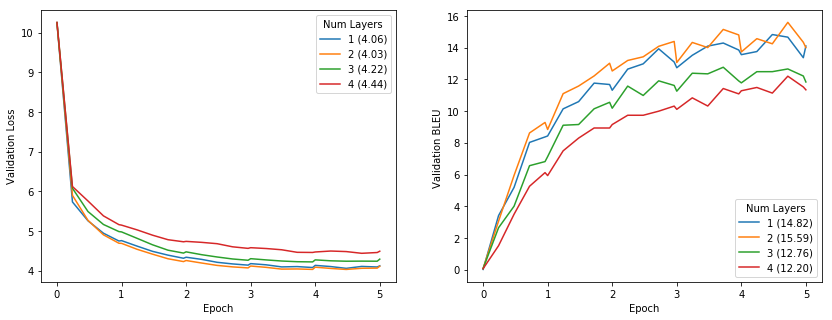

In [11]:
plot_multiple_learning_curves(experiment_results, 'num_layers', 'Num Layers')